<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments/blob/main/Endpoints300s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PROVA MODELLI CENTRALIZZATI PREDIZIONE INVOCATIONS' RATE**



#### Imports

In [208]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

from datasets import load_dataset

# Data

In [209]:
dataset_e1 = load_dataset("anastasiafrosted/endpoint0_300", download_mode="force_redownload")
dataset_e2 = load_dataset("anastasiafrosted/endpoint1_300", download_mode="force_redownload")

df_1 = pd.DataFrame(dataset_e1['train'])
df_2 = pd.DataFrame(dataset_e2['train'])

# Ensure the `timestamp` column is in datetime format
df_1['timestamp'] = pd.to_datetime(df_1['timestamp'])
df_2['timestamp'] = pd.to_datetime(df_2['timestamp'])

train-00000-of-00001.parquet:   0%|          | 0.00/629k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25600 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/327k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22019 [00:00<?, ? examples/s]

In [210]:
data1 = df_1
data1 = data1.set_index("timestamp")
data2 = df_2
data2 = data2.set_index("timestamp")
freq='300s'

In [211]:
origin = "2023-06-15"
start = "2023-07-02" # origin + prediction_lenght
end = "2023-07-08"

train_data1 = data1["2022-12-20":origin]
valid_data1 = data1[origin:start]
test_data1 = data1[start:]

train_data2 = data2["2022-12-20":origin]
valid_data2 = data2[origin:start]
test_data2 = data2[start:]

# List of columns to drop
columns_to_drop = [
    'e_type_LSFProvider', 'e_type_CobaltProvider',
    'e_type_PBSProProvider', 'e_type_LocalProvider',
    'e_type_KubernetesProvider', 'e_type_SlurmProvider'
]
train_data1 = train_data1.drop(columns=columns_to_drop, errors='ignore')
valid_data1 = valid_data1.drop(columns=columns_to_drop, errors='ignore')
test_data1 = test_data1.drop(columns=columns_to_drop, errors='ignore')

train_data2 = train_data2.drop(columns=columns_to_drop, errors='ignore')
valid_data2 = valid_data2.drop(columns=columns_to_drop, errors='ignore')
test_data2 = test_data2.drop(columns=columns_to_drop, errors='ignore')

#### Scaling

In [212]:
from sklearn.preprocessing import StandardScaler

# Crea un'istanza dello scaler
scaler = StandardScaler()

In [213]:
# ENDPOINT 1:

# Per il dataset di training
scaled_train1 = train_data1.copy()
scaled_train1[scaled_train1.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    train_data1[train_data1.columns.drop('avg_invocations_rate')]
)
train1 = scaled_train1

# Per il dataset di validazione
scaled_valid1 = valid_data1.copy()
scaled_valid1[scaled_valid1.columns.drop('avg_invocations_rate')] = scaler.transform(
    valid_data1[valid_data1.columns.drop('avg_invocations_rate')]
)
valid1 = scaled_valid1

# Per il dataset di test
scaled_test1 = test_data1.copy()
scaled_test1[scaled_test1.columns.drop('avg_invocations_rate')] = scaler.transform(
    test_data1[test_data1.columns.drop('avg_invocations_rate')]
)
test1 = scaled_test1

In [214]:
# ENDPOINT 2:

# Per il dataset di training
scaled_train2 = train_data2.copy()
scaled_train2[scaled_train2.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    train_data2[train_data2.columns.drop('avg_invocations_rate')]
)
train2 = scaled_train2

# Per il dataset di validazione
scaled_valid2 = valid_data2.copy()
scaled_valid2[scaled_valid2.columns.drop('avg_invocations_rate')] = scaler.transform(
    valid_data2[valid_data2.columns.drop('avg_invocations_rate')]
)
valid2 = scaled_valid2

# Per il dataset di test
scaled_test2 = test_data2.copy()
scaled_test2[scaled_test2.columns.drop('avg_invocations_rate')] = scaler.transform(
    test_data2[test_data2.columns.drop('avg_invocations_rate')]
)
test2 = scaled_test2

#### Config (Parameters)

In [215]:
batch_size = 32
num_features = 6
sequence_lenght = 7
prediction_lenght = 7

seed = 123
neurons = 32
epochs = 10

# Models

## Forecasting one-step-ahead

In [216]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=epochs):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

### Univariate series

In [217]:
tr1 = train1['avg_invocations_rate']
vl1 = valid1['avg_invocations_rate']
ts1 = test1['avg_invocations_rate'][:-1]

tr2 = train2['avg_invocations_rate']
vl2 = valid2['avg_invocations_rate']
ts2 = test2['avg_invocations_rate'][:-1]

In [218]:
# ENDPOINT 1:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    tr1.to_numpy(),
    targets=tr1[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    vl1.to_numpy(),
    targets=vl1[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    ts1.to_numpy(),
    targets=ts1[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

In [219]:
# ENDPOINT 2:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    tr2.to_numpy(),
    targets=tr2[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    vl2.to_numpy(),
    targets=vl2[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    ts2.to_numpy(),
    targets=ts2[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Linear Model

In [220]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_lenght])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [221]:
fit_and_evaluate(model, train_ds1, valid_ds1)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0027 - mae: 0.0578 - val_loss: 9.6598e-04 - val_mae: 0.0376
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 9.2182e-04 - mae: 0.0351 - val_loss: 5.5576e-04 - val_mae: 0.0274
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 6.1578e-04 - mae: 0.0278 - val_loss: 4.5365e-04 - val_mae: 0.0233
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 5.3235e-04 - mae: 0.0248 - val_loss: 4.2326e-04 - val_mae: 0.0214
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 5.0348e-04 - mae: 0.0235 - val_loss: 4.0247e-04 - val_mae: 0.0208
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 4.8545e-04 - mae: 0.0228 - val_loss: 3.9115e-04 - val_mae: 0.0200
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 4.7454e-04 - mae: 0.0223 - val_loss: 3.7967e-04 - val_mae: 0.0197
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 4.6355e-04 - mae: 0.0220 - val_loss: 3.6956e-04 - 

18759.045749902725

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


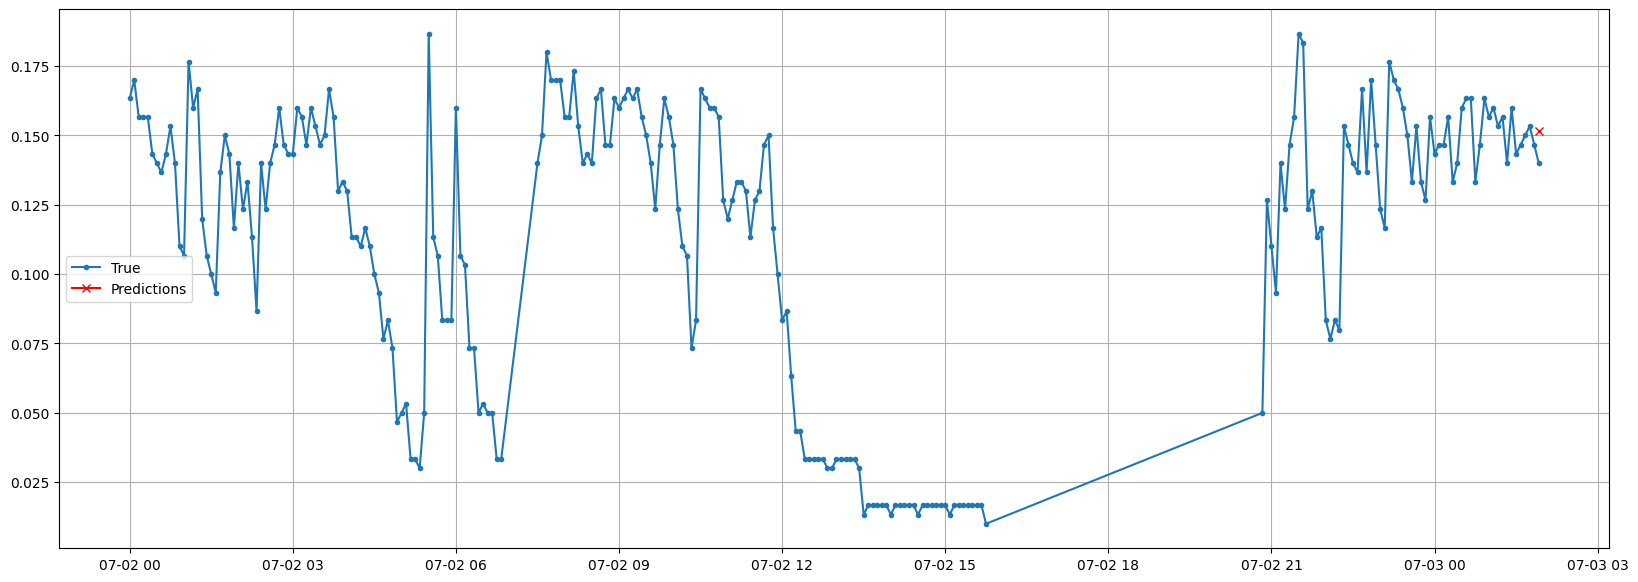

In [222]:
Y_pred = model.predict(test_ds1)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test1.index[-1], end=test1.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [223]:
fit_and_evaluate(model, train_ds2, valid_ds2)

Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 3.0489e-04 - mae: 0.0081 - val_loss: 3.7876e-05 - val_mae: 0.0056
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.9622e-04 - mae: 0.0078 - val_loss: 3.7690e-05 - val_mae: 0.0056
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.9491e-04 - mae: 0.0078 - val_loss: 3.8828e-05 - val_mae: 0.0056
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.8548e-04 - mae: 0.0077 - val_loss: 3.8549e-05 - val_mae: 0.0056
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2.8816e-04 - mae: 0.0077 - val_loss: 3.7482e-05 - val_mae: 0.0056
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.8435e-04 - mae: 0.0077 - val_loss: 4.0158e-05 - val_mae: 0.0058
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.7670e-04 - mae: 0.0077 - val_loss: 3.9266e-05 - val_mae: 0.0057
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2.7683e-04 - mae: 0.0077 - val_loss: 3.9277e-05 - val_mae:

5562.157835811377

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


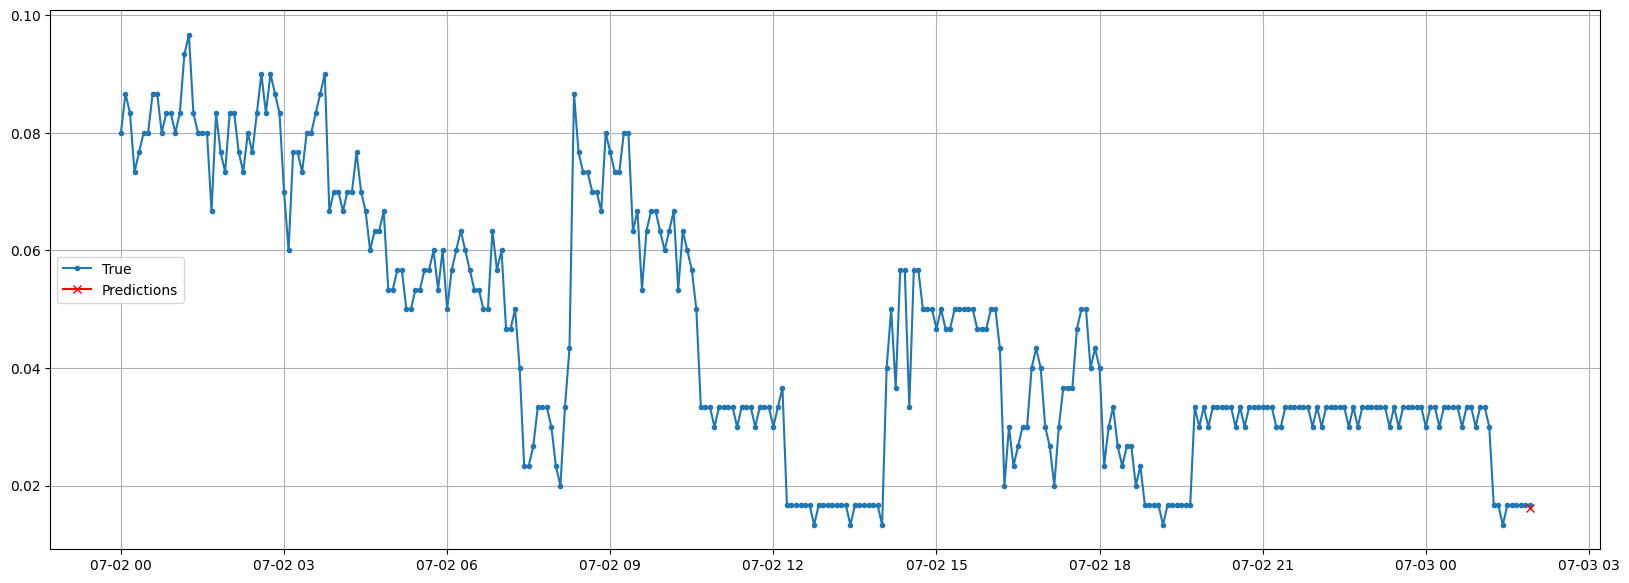

In [224]:
Y_pred = model.predict(test_ds2)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test2.index[-1], end=test2.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Simple RNN

Recall that the input_shape argument ignores
the first dimension (i.e., the batch size), and since recurrent layers can accept
input sequences of any length, we can set the second dimension to None, which
means “any size”. Lastly, since we’re dealing with a univariate time series, we
need the last dimension’s size to be 1. This is why we specified the input shape
* [None, 1] : it means “univariate sequences of any length”.


In [225]:
univar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, input_shape=[None, 1]),
  tf.keras.layers.Dense(1) # no activation function by default
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [226]:
fit_and_evaluate(univar_model, train_ds1, valid_ds1)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0012 - mae: 0.0360 - val_loss: 4.9575e-04 - val_mae: 0.0219
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 4.9196e-04 - mae: 0.0232 - val_loss: 3.4734e-04 - val_mae: 0.0187
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 4.0463e-04 - mae: 0.0209 - val_loss: 2.9915e-04 - val_mae: 0.0170
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 3.6235e-04 - mae: 0.0196 - val_loss: 2.6775e-04 - val_mae: 0.0169
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 3.3957e-04 - mae: 0.0189 - val_loss: 2.4818e-04 - val_mae: 0.0155
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 3.2597e-04 - mae: 0.0184 - val_loss: 2.4071e-04 - val_mae: 0.0146
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 3.1297e-04 - mae: 0.0180 - val_loss: 2.4667e-04 - val_mae: 0.0172
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 3.0097e-04 - mae: 0.0176 - val_loss: 2.1808e-04 - val_mae:

13733.31155627966

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


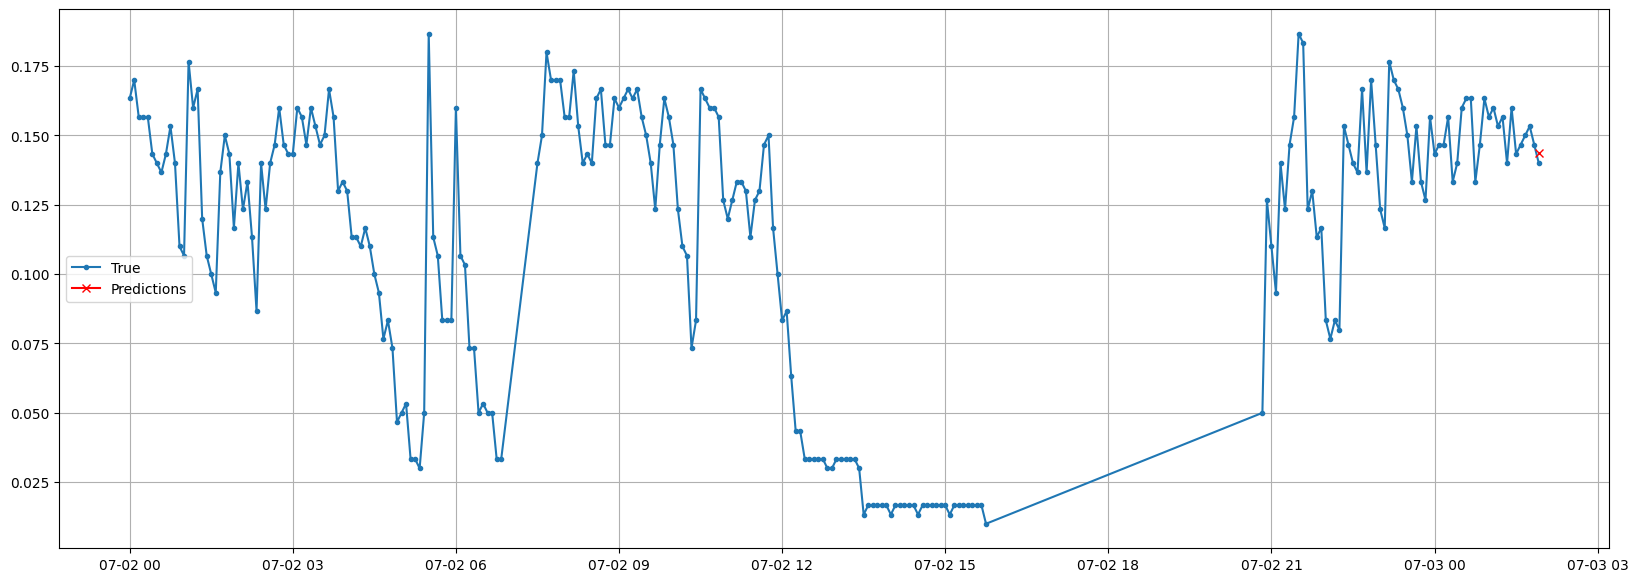

In [227]:
Y_pred = univar_model.predict(test_ds1)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test1.index[-1], end=test1.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [228]:
fit_and_evaluate(univar_model, train_ds2, valid_ds2)

Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.1773e-04 - mae: 0.0072 - val_loss: 2.8892e-05 - val_mae: 0.0049
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.1191e-04 - mae: 0.0069 - val_loss: 2.9612e-05 - val_mae: 0.0050
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.0955e-04 - mae: 0.0069 - val_loss: 2.5050e-05 - val_mae: 0.0050
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 2.0775e-04 - mae: 0.0068 - val_loss: 3.0207e-05 - val_mae: 0.0050
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 2.0091e-04 - mae: 0.0066 - val_loss: 2.5287e-05 - val_mae: 0.0049
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.0405e-04 - mae: 0.0067 - val_loss: 2.6564e-05 - val_mae: 0.0048
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 2.0270e-04 - mae: 0.0068 - val_loss: 2.4137e-05 - val_mae: 0.0049
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.0524e-04 - mae: 0.0069 - val_loss: 2.4798e-05 - val_

4703.9794735610485

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


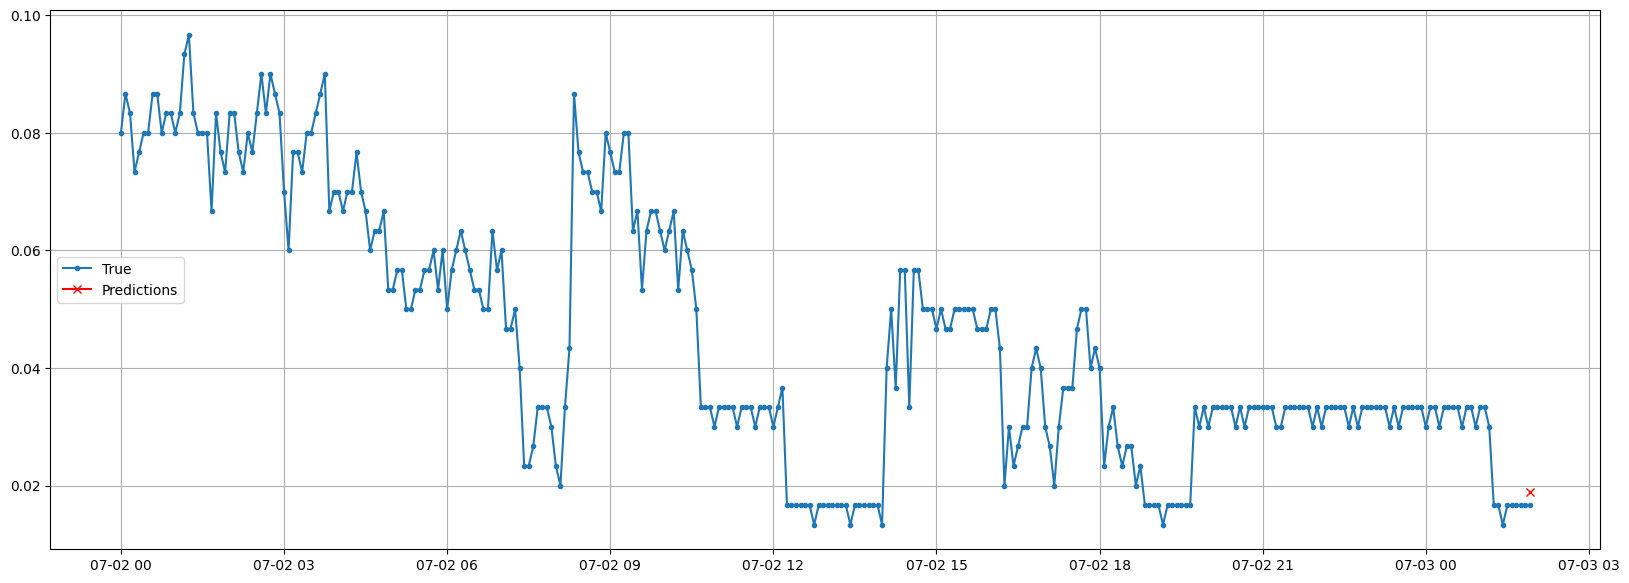

In [229]:
Y_pred = univar_model.predict(test_ds2)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test2.index[-1], end=test2.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Deep RNN

In [230]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons*3, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True),
    tf.keras.layers.SimpleRNN(neurons),
    tf.keras.layers.Dense(1)
])

In [231]:
fit_and_evaluate(deep_model, train_ds1, valid_ds1)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0034 - mae: 0.0428 - val_loss: 3.7454e-04 - val_mae: 0.0198
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 3.3894e-04 - mae: 0.0193 - val_loss: 2.4945e-04 - val_mae: 0.0148
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 3.0992e-04 - mae: 0.0182 - val_loss: 2.0949e-04 - val_mae: 0.0145
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 2.9514e-04 - mae: 0.0176 - val_loss: 2.2452e-04 - val_mae: 0.0137
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 2.9104e-04 - mae: 0.0175 - val_loss: 2.0456e-04 - val_mae: 0.0147
Epoch 6/10
644/704 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.8242e-04 - mae: 0.0170

KeyboardInterrupt: 

In [ ]:
Y_pred = deep_model.predict(test_ds1)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test1.index[-1], end=test1.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [ ]:
fit_and_evaluate(deep_model, train_ds2, valid_ds2)

In [ ]:
Y_pred = deep_model.predict(test_ds2)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test2.index[-1], end=test2.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

### Multivariate Series

In [ ]:
# ENDPOINT 1:

tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    train1,
    targets=train1['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    valid1,
    targets=valid1['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_mulvar_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    test1,
    targets=test1['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

In [ ]:
# ENDPOINT 2:

tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    train2,
    targets=train2['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    valid2,
    targets=valid2['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_mulvar_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    test2,
    targets=test2['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Simple RNN

Notice that the only difference from the univar_model RNN we built earlier
is the input shape: at each time step, the model now receives num_features inputs instead of one.

In [ ]:
mulvar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(1)
])

In [ ]:
fit_and_evaluate(mulvar_model, train_mulvar_ds1, valid_mulvar_ds1)

In [ ]:
Y_pred = mulvar_model.predict(test_mulvar_ds1)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test1.index[-1], end=test1.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [ ]:
fit_and_evaluate(mulvar_model, train_mulvar_ds2, valid_mulvar_ds2)

In [ ]:
Y_pred = mulvar_model.predict(test_mulvar_ds2)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test2.index[-1], end=test2.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

## Forecasting Several Time Steps Ahead

### Univariate Series

Consideriamo sempre:
* tr = train['avg_invocations_rate']
* vl = valid['avg_invocations_rate']

#### Simple RNN

The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the inputs,
acting as if the predicted value had actually occurred; we would then use the
model again to predict the following value, and so on.

---
If the model makes an error at one time step, then the forecasts for the
following time steps are impacted as well: the errors tend to accumulate.
So, it’s preferable to use this technique only for a small number of steps.

In [ ]:
X = ts1[:-sequence_lenght].to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [ ]:
X = ts2[:-sequence_lenght].to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

### Multivariate Series

In [ ]:
def split_inputs_and_targets(mulvar_series, ahead=prediction_lenght, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

In [ ]:
# ENDPOINT 1:

ahead_train_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    train1,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    valid1,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

ahead_test_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    test1,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

In [ ]:
# ENDPOINT 2:

ahead_train_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    train2,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    valid2,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

ahead_test_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    test2,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

#### Sequence-to-Vector RNN

Train an RNN to predict the next 14 values in one shot.

In [ ]:
ahead_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

In [ ]:
fit_and_evaluate(ahead_model, ahead_train_ds1, ahead_valid_ds1)

In [ ]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X)
Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [ ]:
fit_and_evaluate(ahead_model, ahead_train_ds2, ahead_valid_ds2)

In [ ]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X)
Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### Sequence-to-Sequence RNN

In [ ]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(8 * batch_size, seed=seed)
  return ds.batch(batch_size)

In [ ]:
seq2seq_train1 = to_seq2seq_dataset(train1, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid1 = to_seq2seq_dataset(valid1, seq_length=sequence_lenght, ahead=prediction_lenght)
seq2seq_test1 = to_seq2seq_dataset(test1, seq_length=sequence_lenght, ahead=prediction_lenght)

seq2seq_train2 = to_seq2seq_dataset(train2, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid2 = to_seq2seq_dataset(valid2, seq_length=sequence_lenght, ahead=prediction_lenght)
seq2seq_test2 = to_seq2seq_dataset(test2, seq_length=sequence_lenght, ahead=prediction_lenght)

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step.
In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.

* The targets are sequences of consecutive windows, shifted by one time step at each time step;
* The target is not a vector anymore, but a sequence of the same length as the inputs, containing a (prediction_lenght)-dimensional vector at each step.

It is almost identical to our previous model: the only difference is that we set
return_sequences=True in the SimpleRNN layer. This way, it will
output a sequence of vectors (each of size 'batch_size'), instead of outputting a single
vector at the last time step. The Dense layer is smart enough to handle
sequences as input: it will be applied at each time step, taking a 'batch_size'-dimensional
vector as input and outputting a 'prediction_lenght'-dimensional vector.

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

In [ ]:
fit_and_evaluate(seq2seq_model, seq2seq_train1, seq2seq_valid1)

In [ ]:
Y_pred_valid = seq2seq_model.predict(seq2seq_test1)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=test1.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - test1["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

In [ ]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [205]:
fit_and_evaluate(seq2seq_model, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
    586/Unknown 15s 19ms/step - loss: 0.1423 - mae: 0.2721

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.1423 - mae: 0.2722 - val_loss: 0.0324 - val_mae: 0.0967
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.1408 - mae: 0.2707 - val_loss: 0.0337 - val_mae: 0.1017
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.1431 - mae: 0.2735 - val_loss: 0.0322 - val_mae: 0.0998
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.1427 - mae: 0.2729 - val_loss: 0.0296 - val_mae: 0.0906
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1400 - mae: 0.2688 - val_loss: 0.0314 - val_mae: 0.0943
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1391 - mae: 0.2687 - val_loss: 0.0307 - val_mae: 0.0907
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.1405 - mae: 0.2702 - val_loss: 0.0301 - val_mae: 0.0896
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.1398 - mae: 0.2690 - val_loss: 0.0294 - val_mae: 0.0902
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step -

86372.52449989319

In [206]:
Y_pred_valid = seq2seq_model.predict(seq2seq_test2)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=test2.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - test2["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
MAE for +1: 285,762
MAE for +2: 289,879
MAE for +3: 255,429
MAE for +4: 259,979
MAE for +5: 273,968
MAE for +6: 248,407
MAE for +7: 258,377


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


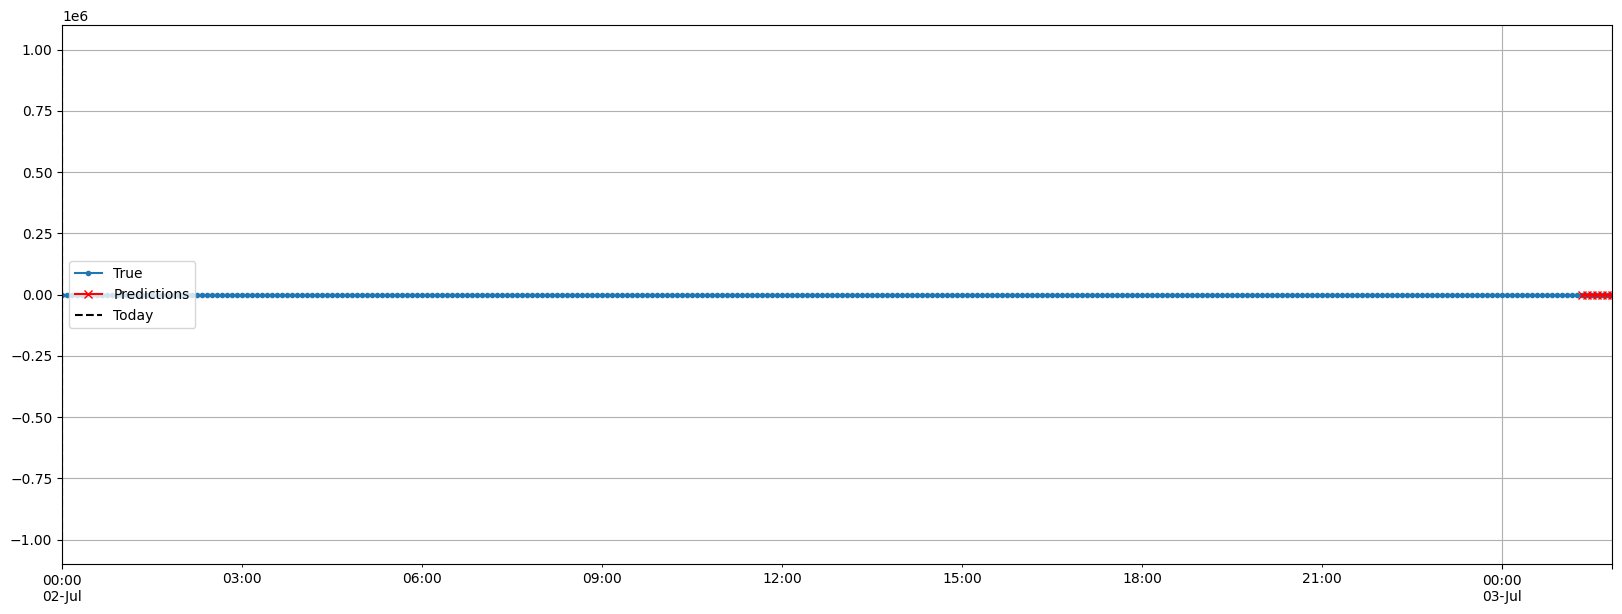

In [207]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### RNN with layer normalization

In [ ]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(neurons), return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
])

In [ ]:
fit_and_evaluate(custom_ln_model, seq2seq_train1, seq2seq_valid1)

In [ ]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [ ]:
fit_and_evaluate(custom_ln_model, seq2seq_train2, seq2seq_valid2)

In [ ]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2 * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 #### LSTM

In [ ]:
lstm = tf.keras.Sequential([
  tf.keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

In [ ]:
fit_and_evaluate(lstm, seq2seq_train1, seq2seq_valid1)

In [ ]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [ ]:
fit_and_evaluate(lstm, seq2seq_train2, seq2seq_valid2)

In [ ]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### GRU

The GRU cell is a simplified version of the LSTM cell...

In [ ]:
gru = tf.keras.Sequential([
  tf.keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

In [ ]:
fit_and_evaluate(gru, seq2seq_train1, seq2seq_valid1)

In [ ]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [ ]:
fit_and_evaluate(gru, seq2seq_train2, seq2seq_valid2)

In [ ]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### CNN

In [ ]:
seq2seq_cnn_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Conv1D(prediction_lenght, kernel_size=1)
])

In [ ]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train1, seq2seq_valid1)

In [ ]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [ ]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train2, seq2seq_valid2)

In [ ]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

LSTM and GRU cells are one of the main reasons behind the success of RNNs.
Yet while they can tackle much longer sequences than simple RNNs, they still
have a fairly limited short-term memory, and they have a hard time learning
long-term patterns in sequences of 100 time steps or more, such as audio
samples, long time series, or long sentences. One way to solve this is to shorten
the input sequences; for example, using 1D convolutional layers.

In [ ]:
stride = 2
k_size = 4

conv_rnn_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=k_size, strides=stride, activation="relu", input_shape=[None, num_features]),
  tf.keras.layers.GRU(batch_size, return_sequences=True),
  tf.keras.layers.Dense(prediction_lenght)
])

In [ ]:
# ENDPOINT 1:
longer_train1 = to_seq2seq_dataset(train1, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid1 = to_seq2seq_dataset(valid1, seq_length=sequence_lenght*2)
longer_test1 = to_seq2seq_dataset(test1, seq_length=sequence_lenght*2)
downsampled_train1 = longer_train1.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid1 = longer_valid1.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_test1 = longer_test1.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [ ]:
fit_and_evaluate(conv_rnn_model, downsampled_train1, downsampled_valid1)

In [ ]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [ ]:
# ENDPOINT 2:
longer_train2 = to_seq2seq_dataset(train2, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid2 = to_seq2seq_dataset(valid2, seq_length=sequence_lenght*2)
longer_test2 = to_seq2seq_dataset(test2, seq_length=sequence_lenght*2)
downsampled_train2 = longer_train2.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid2 = longer_valid2.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_test2 = longer_test2.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [ ]:
fit_and_evaluate(conv_rnn_model, downsampled_train2, downsampled_valid2)

In [ ]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

## ARMA family



In [ ]:
from statsmodels.tsa.arima.model import ARIMA

Check for stationarity with the Augmented Dickey-Fuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller

print("Endpoint 1:")
result1 = adfuller(train1['avg_invocations_rate'])
print('ADF Statistic:', result1[0])
print('p-value:', result1[1])
print("Endpoint 2:")
result2 = adfuller(train2['avg_invocations_rate'])
print('ADF Statistic:', result2[0])
print('p-value:', result2[1])

In [ ]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(train1['avg_invocations_rate'], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(train1['avg_invocations_rate'], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

In [ ]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(train2['avg_invocations_rate'], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(train2['avg_invocations_rate'], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

order=(p, d, q):
* p = the past p values of the time series, "how far back into the past the model should look";
* d = *order of integration*, running d consecutive rounds of differencing computes an approximation of the dth order derivative of the time series, so it will eliminate polynomial trends up to degree d.
* q = the past q forecast errors ε(t);

seasonal_order=(P, D, Q, s)
* P = , D = , Q =  : to model the time series at  (t–s), (t–2s), (t–3s);
* s = the period of the seasonal pattern.


In [ ]:
trimmed_valid1 = ts1.iloc[:-prediction_lenght]
# in realtà dal test risulta stazionaria, ma le performance sembrano migliori
arima = ARIMA(trimmed_valid1, order=(1,1,1))
arima = arima.fit()

In [ ]:
# Forecasting
forecast1 = arima.forecast(steps=prediction_lenght)

plt.figure(figsize=(20, 6))
# Plot the forecast
# original data: full length
plt.plot(ts1.index, ts1, label='Observed')
plt.plot(pd.date_range(trimmed_valid1.index[-1], periods=prediction_lenght, freq=freq), forecast1, label='Forecast', color='red')
plt.axvline(trimmed_valid1.index[-1], linestyle='--', color='black', label='Forecast Start')
plt.legend()
plt.grid()
plt.show()

In [ ]:
trimmed_valid2 = ts2.iloc[:-prediction_lenght]
# in realtà dal test risulta stazionaria, ma le performance sembrano migliori
arima = ARIMA(trimmed_valid2, order=(1,1,1))
arima = arima.fit()

In [ ]:
# Forecasting
forecast2 = arima.forecast(steps=prediction_lenght)

plt.figure(figsize=(20, 6))
# Plot the forecast
# original data: full length
plt.plot(ts2.index, ts2, label='Observed')
plt.plot(pd.date_range(trimmed_valid2.index[-1], periods=prediction_lenght, freq=freq), forecast2, label='Forecast', color='red')
plt.axvline(trimmed_valid2.index[-1], linestyle='--', color='black', label='Forecast Start')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(forecast1)